<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/TX_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the TX data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea:


*   compute 7 -day moving average
*   14 days data compare with next 14 days rolling window
*   split the % as buckets
*   label the data as per bucket

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
import jenkspy

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [4]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_labeledData_Sep09
CA_labeledData_Sep14.csv
CA_labeledData_Sep17.csv
CA_sd_inertia_labeledData_Sep09
CA_sd_inertia_labeledData_Sep14.csv
CA_sd_inertia_labeledData_Sep17.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv
TX_combined_Sep10.csv
TX-Covid_Sep10.csv
TX_labeledData_Sep16.csv
TX_labeledData_Sep17.csv
TX_socialDistancingInertiaData_Sep10.csv


### 1.1 Loading CA data

In [5]:
TX_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/TX_combined_Sep10.csv',low_memory=False)
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0


In [ ]:
TX_combined_data.iloc[:,15]

0        0
1        0
2        0
3        0
4        0
        ..
36774    0
36775    0
36776    3
36777    2
36778    0
Name: New cases, Length: 36779, dtype: int64

In [ ]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])

In [ ]:
TX_counties = TX_combined_data['County Name'].unique()

for county in TX_counties:
  county_data = TX_combined_data[TX_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,NaN


In [ ]:
print(df.shape)
TX_combined_data.shape

(36779, 17)


(36779, 16)

In [ ]:
TX_combined_data = df.copy()
TX_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.000,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.333710,0,0.000,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.333710,0,0.000,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.333710,0,0.000,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.333710,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36774,2020-08-31,48507,Zavala County,0.0,0.0,0.0,0.0,-30.0,0.0,0.00,2.292,23,9.125874,1,0.635,0,1.714286
36775,2020-09-01,48507,Zavala County,0.0,0.0,0.0,0.0,-30.0,0.0,0.00,3.324,34,9.125874,1,0.635,0,1.142857
36776,2020-09-02,48507,Zavala County,0.0,0.0,0.0,0.0,-31.0,0.0,0.00,7.657,79,9.125874,1,0.635,3,1.571429
36777,2020-09-03,48507,Zavala County,0.0,0.0,0.0,0.0,-33.0,0.0,0.00,3.479,36,9.125874,1,0.635,2,1.285714


In [ ]:
TX_combined_data[TX_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,48001,Anderson County,-6.0,5.0,0.0,0.0,-6.0,0.0,104.48,7.538,67,54.333710,1,0.541,13,9.857143
340,2020-08-01,48003,Andrews County,0.0,0.0,0.0,-22.0,-25.0,0.0,-17.41,2.809,60,12.464100,1,0.597,0,4.285714
529,2020-08-01,48005,Angelina County,-15.0,5.0,-3.0,-2.0,-14.0,4.0,62.99,7.438,76,108.695380,1,0.536,41,34.571429
718,2020-08-01,48007,Aransas County,13.0,16.0,44.0,0.0,-15.0,0.0,220.00,5.184,108,93.267743,1,0.746,0,4.285714
1040,2020-08-01,48013,Atascosa County,-7.0,-7.0,0.0,-28.0,-14.0,0.0,25.00,9.122,52,41.944504,1,0.802,0,1.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35697,2020-08-01,48495,Winkler County,0.0,0.0,0.0,0.0,-40.0,0.0,-49.49,22.197,72,9.523130,1,0.581,2,0.428571
35886,2020-08-01,48497,Wise County,-4.0,11.0,26.0,-2.0,-11.0,0.0,72.10,15.273,70,77.379978,1,0.649,2,5.571429
36075,2020-08-01,48499,Wood County,3.0,15.0,0.0,0.0,-9.0,0.0,72.77,10.248,58,70.577933,1,0.526,7,7.142857
36264,2020-08-01,48501,Yoakum County,0.0,0.0,0.0,0.0,0.0,0.0,17.32,7.017,68,10.895200,1,0.561,8,3.142857


In [ ]:
TX_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,NaN
5,2020-03-06,48001,Anderson County,8.0,10.0,0.0,0.0,3.0,-1.0,85.64,13.757,122,54.33371,0,0.0,0,NaN
6,2020-03-07,48001,Anderson County,9.0,12.0,0.0,0.0,-1.0,0.0,97.15,11.261,100,54.33371,0,0.0,0,0.0
7,2020-03-08,48001,Anderson County,13.0,18.0,0.0,0.0,1.0,0.0,30.01,9.883,88,54.33371,0,0.0,0,0.0


## clean data - fill NA

In [ ]:
TX_combined_data = TX_combined_data.fillna(0)
TX_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,0.0
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,0.0
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,0.0
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,0.0
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,0.0
5,2020-03-06,48001,Anderson County,8.0,10.0,0.0,0.0,3.0,-1.0,85.64,13.757,122,54.33371,0,0.0,0,0.0
6,2020-03-07,48001,Anderson County,9.0,12.0,0.0,0.0,-1.0,0.0,97.15,11.261,100,54.33371,0,0.0,0,0.0
7,2020-03-08,48001,Anderson County,13.0,18.0,0.0,0.0,1.0,0.0,30.01,9.883,88,54.33371,0,0.0,0,0.0


In [ ]:
TX_combined_data['County Name'].unique()

array(['Anderson County', 'Andrews County', 'Angelina County',
       'Aransas County', 'Archer County', 'Atascosa County',
       'Austin County', 'Bailey County', 'Bandera County',
       'Bastrop County', 'Bee County', 'Bell County', 'Bexar County',
       'Blanco County', 'Bosque County', 'Bowie County',
       'Brazoria County', 'Brazos County', 'Brewster County',
       'Brooks County', 'Brown County', 'Burleson County',
       'Burnet County', 'Caldwell County', 'Calhoun County',
       'Callahan County', 'Cameron County', 'Camp County',
       'Carson County', 'Cass County', 'Castro County', 'Chambers County',
       'Cherokee County', 'Childress County', 'Clay County',
       'Coleman County', 'Collin County', 'Colorado County',
       'Comal County', 'Comanche County', 'Cooke County',
       'Coryell County', 'Crane County', 'Crockett County',
       'Culberson County', 'Dallam County', 'Dallas County',
       'Dawson County', 'Deaf Smith County', 'Delta County',
       'Dent

## verifying Rolling average with visualizations - Austin County

In [ ]:
austin_county = TX_combined_data[TX_combined_data['County Name'] == 'Austin County']
print(austin_county.shape)
austin_county.head()

(189, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
1078,2020-03-01,48015,Austin County,15.0,10.0,0.0,0.0,4.0,0.0,45.92,14.176,60,46.452491,0,0.0,0,0.0
1079,2020-03-02,48015,Austin County,11.0,-2.0,0.0,0.0,6.0,-2.0,11.06,23.325,100,46.452491,0,0.0,0,0.0
1080,2020-03-03,48015,Austin County,10.0,2.0,0.0,0.0,6.0,-2.0,11.56,19.812,84,46.452491,0,0.0,0,0.0
1081,2020-03-04,48015,Austin County,12.0,-6.0,0.0,0.0,1.0,0.0,15.45,21.654,92,46.452491,0,0.0,0,0.0
1082,2020-03-05,48015,Austin County,17.0,6.0,0.0,0.0,1.0,-2.0,61.23,24.770,106,46.452491,0,0.0,0,0.0


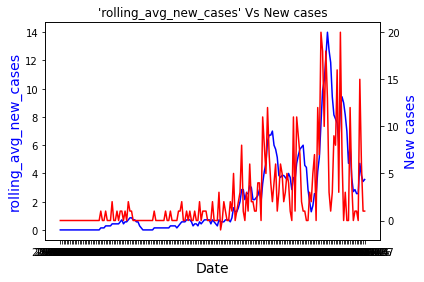

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.Date, austin_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(austin_county.Date, austin_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## verifying Rolling average with visualizations - Dallas County

In [ ]:
dallas_county = TX_combined_data[TX_combined_data['County Name'] == 'Dallas County']

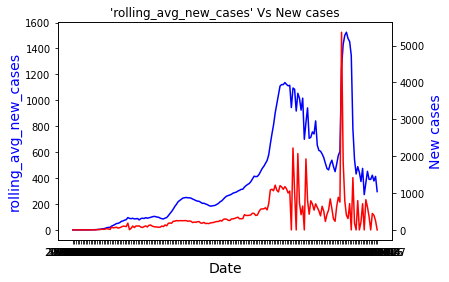

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(dallas_county.Date, dallas_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dallas_county.Date, dallas_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [ ]:
TX_combined_data = TX_combined_data.sort_values(by=['Date'])
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0
1782,2020-03-01,48025,Bee County,31.0,4.0,0.0,0.0,-2.0,0.0,11.85,4.763,92,36.995592,0,0.0,0,0.0
24178,2020-03-01,48343,Morris County,18.0,11.0,0.0,0.0,0.0,0.0,0.00,11.618,60,49.160681,0,0.0,0,0.0
24333,2020-03-01,48347,Nacogdoches County,9.0,14.0,2.0,0.0,6.0,0.0,7.71,5.284,94,68.886682,0,0.0,0,0.0
24522,2020-03-01,48349,Navarro County,23.0,14.0,0.0,23.0,2.0,0.0,40.47,6.304,54,49.635015,0,0.0,0,0.0


In [ ]:
TX_combined_data[TX_combined_data['fips_x'] == 48015]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
1078,2020-03-01,48015,Austin County,15.0,10.0,0.0,0.0,4.0,0.0,45.92,14.176,60,46.452491,0,0.000,0,0.000000
1079,2020-03-02,48015,Austin County,11.0,-2.0,0.0,0.0,6.0,-2.0,11.06,23.325,100,46.452491,0,0.000,0,0.000000
1080,2020-03-03,48015,Austin County,10.0,2.0,0.0,0.0,6.0,-2.0,11.56,19.812,84,46.452491,0,0.000,0,0.000000
1081,2020-03-04,48015,Austin County,12.0,-6.0,0.0,0.0,1.0,0.0,15.45,21.654,92,46.452491,0,0.000,0,0.000000
1082,2020-03-05,48015,Austin County,17.0,6.0,0.0,0.0,1.0,-2.0,61.23,24.770,106,46.452491,0,0.000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,2020-09-03,48015,Austin County,1.0,13.0,0.0,0.0,-29.0,0.0,53.23,14.203,60,46.452491,1,0.692,0,2.571429
1263,2020-09-04,48015,Austin County,2.0,10.0,0.0,0.0,-28.0,0.0,157.21,19.235,82,46.452491,1,0.692,15,4.714286
1264,2020-09-05,48015,Austin County,-2.0,10.0,0.0,0.0,-21.0,0.0,114.36,12.179,52,46.452491,1,0.692,6,3.857143
1265,2020-09-06,48015,Austin County,-10.0,0.0,0.0,0.0,-14.0,0.0,78.82,8.466,36,46.452491,1,0.692,1,3.428571


In [ ]:
minDate = TX_combined_data['Date'].min()
print(minDate)

dateList = TX_combined_data['Date'].unique()

2020-03-01


In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)

[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-31']
[14, '2020-09-01', '2020-09-07']


In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


In [ ]:
average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (TX_combined_data['Date'] >= startDate) & (TX_combined_data['Date'] <= endDate)
    df_weekData =  TX_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)

In [ ]:
average_newCases_df.shape

(2835, 5)

In [ ]:
average_newCases_df[average_newCases_df['fips_x'] == 48015]

,County Name,fips_x,average_per_week,startDate,endDate
6,Austin County,48015,0.000000,2020-03-01,2020-03-14
6,Austin County,48015,0.030612,2020-03-15,2020-03-28
6,Austin County,48015,0.438776,2020-03-29,2020-04-11
6,Austin County,48015,0.387755,2020-04-12,2020-04-26
6,Austin County,48015,0.142857,2020-04-27,2020-05-10
6,Austin County,48015,0.469388,2020-05-11,2020-05-24
6,Austin County,48015,0.540816,2020-05-25,2020-06-08
6,Austin County,48015,0.979592,2020-06-09,2020-06-22
6,Austin County,48015,2.591837,2020-06-23,2020-07-06
6,Austin County,48015,5.102041,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [ ]:
austin_county[(austin_county['Date'] >= '2020-03-01') & (austin_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']

1078    0.0
1079    0.0
1080    0.0
1081    0.0
1082    0.0
1083    0.0
1084    0.0
1085    0.0
1086    0.0
1087    0.0
1088    0.0
1089    0.0
1090    0.0
1091    0.0
Name: rolling_avg_new_cases, dtype: float64

In [ ]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14
5,Atascosa County,48013,0.0,2020-03-01,2020-03-14
6,Austin County,48015,0.0,2020-03-01,2020-03-14
7,Bailey County,48017,0.0,2020-03-01,2020-03-14
8,Bandera County,48019,0.0,2020-03-01,2020-03-14
9,Bastrop County,48021,0.0,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [ ]:
average_newCases_df_ = average_newCases_df.copy()

In [ ]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Austin County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
6,Austin County,48015,0.000000,2020-03-01,2020-03-14
6,Austin County,48015,0.030612,2020-03-15,2020-03-28
6,Austin County,48015,0.438776,2020-03-29,2020-04-11
6,Austin County,48015,0.387755,2020-04-12,2020-04-26
6,Austin County,48015,0.142857,2020-04-27,2020-05-10
6,Austin County,48015,0.469388,2020-05-11,2020-05-24
6,Austin County,48015,0.540816,2020-05-25,2020-06-08
6,Austin County,48015,0.979592,2020-06-09,2020-06-22
6,Austin County,48015,2.591837,2020-06-23,2020-07-06
6,Austin County,48015,5.102041,2020-07-07,2020-07-20


In [ ]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14


In [ ]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14


In [ ]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()

(2835, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Dallas County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
46,Dallas County,48113,0.224490,2020-03-01,2020-03-14,0.000000
250,Dallas County,48113,18.255102,2020-03-15,2020-03-28,18.030612
452,Dallas County,48113,78.102041,2020-03-29,2020-04-11,59.846939
655,Dallas County,48113,94.530612,2020-04-12,2020-04-26,16.428571
858,Dallas County,48113,168.602041,2020-04-27,2020-05-10,74.071429
1061,Dallas County,48113,225.091837,2020-05-11,2020-05-24,56.489796
1264,Dallas County,48113,218.693878,2020-05-25,2020-06-08,-6.397959
1467,Dallas County,48113,322.846939,2020-06-09,2020-06-22,104.153061
1669,Dallas County,48113,559.051020,2020-06-23,2020-07-06,236.204082
1871,Dallas County,48113,1067.571429,2020-07-07,2020-07-20,508.520408


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Houston County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
90,Houston County,48225,0.000000,2020-03-01,2020-03-14,0.000000
293,Houston County,48225,0.000000,2020-03-15,2020-03-28,0.000000
496,Houston County,48225,0.000000,2020-03-29,2020-04-11,0.000000
699,Houston County,48225,0.316327,2020-04-12,2020-04-26,0.316327
902,Houston County,48225,0.367347,2020-04-27,2020-05-10,0.051020
1105,Houston County,48225,5.112245,2020-05-11,2020-05-24,4.744898
1308,Houston County,48225,4.306122,2020-05-25,2020-06-08,-0.806122
1510,Houston County,48225,0.438776,2020-06-09,2020-06-22,-3.867347
1712,Houston County,48225,1.346939,2020-06-23,2020-07-06,0.908163
1914,Houston County,48225,2.448980,2020-07-07,2020-07-20,1.102041


In [ ]:
average_newCases_df2[average_newCases_df2['fips_x'] == 48015].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898


In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name     fips_x startDate  endDate                       ...             
Anderson County 48001  2020-03-01 2020-03-14          0.000000  ...     0.000000
                       2020-03-15 2020-03-28          0.000000  ...     0.000000
                       2020-03-29 2020-04-11          0.142857  ...     0.000000
                       2020-04-12 2020-04-26          0.908163  ...     0.142857
                       2020-04-27 2020-05-10          1.755102  ...     0.908163
...                                                        ...  ...          ...
Zavala County   48507  2020-07-07 2020-07-20          3.400000  ...     0.728571
                       2020-07-21 2020-08-03          7.314286  ...     3.400000
                       2020-08-04 2020-08-17          5.614286  ...     7.314286
                       2020-08-18 2020-08-31          2.500000  ...     5.614286
                       2020-09-01 2020-09-07          1.250000  ...     2.500000

[2835 rows x 3 columns]

In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000,NaN
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612,0.000000
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163,0.030612
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020,0.438776
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898,0.387755
1021,Austin County,48015,0.469388,2020-05-11,2020-05-24,0.326531,0.142857
1224,Austin County,48015,0.540816,2020-05-25,2020-06-08,0.071429,0.469388
1427,Austin County,48015,0.979592,2020-06-09,2020-06-22,0.438776,0.540816
1629,Austin County,48015,2.591837,2020-06-23,2020-07-06,1.612245,0.979592
1831,Austin County,48015,5.102041,2020-07-07,2020-07-20,2.510204,2.591837


In [ ]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
2830,Wood County,48499,2.938776,2020-09-01,2020-09-07,-0.193878,3.132653,-0.061889
2831,Yoakum County,48501,3.000000,2020-09-01,2020-09-07,1.193878,1.806122,0.661017
2832,Young County,48503,0.102041,2020-09-01,2020-09-07,-2.377551,2.479592,-0.958848
2833,Zapata County,48505,4.107143,2020-09-01,2020-09-07,-1.121429,5.228571,-0.214481
2834,Zavala County,48507,1.250000,2020-09-01,2020-09-07,-1.250000,2.500000,-0.500000


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612,0.000000,0.000000
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163,0.030612,13.333333
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020,0.438776,-0.116279
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898,0.387755,-0.631579
1021,Austin County,48015,0.469388,2020-05-11,2020-05-24,0.326531,0.142857,2.285714
1224,Austin County,48015,0.540816,2020-05-25,2020-06-08,0.071429,0.469388,0.152174
1427,Austin County,48015,0.979592,2020-06-09,2020-06-22,0.438776,0.540816,0.811321
1629,Austin County,48015,2.591837,2020-06-23,2020-07-06,1.612245,0.979592,1.645833
1831,Austin County,48015,5.102041,2020-07-07,2020-07-20,2.510204,2.591837,0.968504


## 1.2 Labeling data as per % change

In [ ]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,2835.000000,2835.000000,2835.000000,2630.000000,2.835000e+03
mean,48256.880776,17.067691,1.515264,16.763970,1.906286e+13
std,151.665163,80.681308,33.513334,80.815555,1.014996e+15
min,48001.000000,-23.387755,-664.510204,-4.397959,-2.900000e+01
25%,48121.000000,0.112245,-0.173469,0.095238,-1.818435e-01
50%,48255.000000,1.142857,0.051020,1.000000,0.000000e+00
75%,48389.000000,5.770408,0.953061,5.364796,8.738819e-01
max,48507.000000,1405.377551,647.938776,1405.377551,5.404320e+16


In [ ]:
austin_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

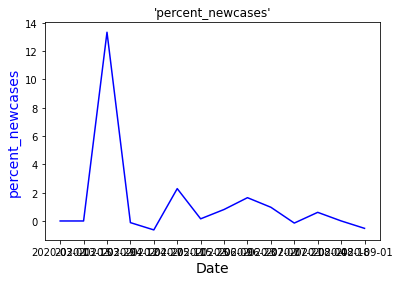

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.startDate, austin_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(austin_county.startDate, austin_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [ ]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [ ]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


In [ ]:
new_cases_list = average_newCases_df2['percent_newcases'].values

### Determining growth label for covid cases

In [ ]:
len(new_cases_list)

2835

In [ ]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

2834


0.0

In [ ]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  2835


In [ ]:
len(growth_values)

2835

In [ ]:
average_newCases_df2['growth_per_day'] = growth_values

In [ ]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [ ]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -5.4043195528445944e+16
max  5.4043195528445944e+16
mean  -0.001653832221906116
std. deviation  1435674859673999.2
variance  2.0611623026999576e+30


#### Getting positive cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


length diffArr:  2834
non_zero_pos_diff length:  1220


In [ ]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  1.431603373858755e-16
max  5.4043195528445944e+16
mean  44297701252828.336
std. deviation  1546617937284705.2
variance  2.3920270439307966e+30


#### Getting negative cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

length diffArr:  2834
non_zero_neg_diff length :  1176


In [ ]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  -5.4043195528445944e+16
max  -1.942890293094024e-16
mean  -45955098238478.38
std. deviation  1575261403252396.0
variance  2.4814484885767074e+30


### Trying natural breaks

In [ ]:
!pip install jenkspy

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.1.6-cp36-cp36m-linux_x86_64.whl size=68261 sha256=f6e4b800c1bb50823aa470fe7ff8bbc44e607046a84721470e047034df55bda2
  Stored in directory: /root/.cache/pip/wheels/5b/8c/58/5022a1b7f3121b8f7a1caaa394480d3cfbd4b439fee2a00cbf
Successfully built jenkspy


In [ ]:
import jenkspy

In [ ]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[1.431603373858755e-16, 228.38461538461544, 5.4043195528445944e+16]
[-5.4043195528445944e+16, -221.12592592592597, -1.942890293094024e-16]


In [ ]:
def determine_growth_label(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [ ]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


## Jenks Natural breaks

In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-29.00000000000002, 66.42857142857143, 228.00000000000006, 5.4043195528445944e+16]


In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-29.00000000000002, 2.0138888888888884, 8.194444444444445, 19.63636363636364, 42.00000000000001, 80.31818181818184, 154.60000000000002, 228.00000000000006, 5.4043195528445944e+16]


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())

Number of records in LessSpread: 2411
Number of records in Spread: 301
Number of records in SuperSpread: 79
Number of records in SuperSpread2: 24
Number of records in SuperSpread3: 10
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 3
Number of records in SuperSpread6: 1


In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-29.00000000000002, 14.999999999999998, 80.31818181818184, 228.00000000000006, 5.4043195528445944e+16]


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 2770
Number of records in Spread: 55
Number of records in SuperSpread: 8
Number of records in SuperSpread: 1


In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


## 1.3 Labeling data for CA combined

In [ ]:
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0
1782,2020-03-01,48025,Bee County,31.0,4.0,0.0,0.0,-2.0,0.0,11.85,4.763,92,36.995592,0,0.0,0,0.0
24178,2020-03-01,48343,Morris County,18.0,11.0,0.0,0.0,0.0,0.0,0.00,11.618,60,49.160681,0,0.0,0,0.0
24333,2020-03-01,48347,Nacogdoches County,9.0,14.0,2.0,0.0,6.0,0.0,7.71,5.284,94,68.886682,0,0.0,0,0.0
24522,2020-03-01,48349,Navarro County,23.0,14.0,0.0,23.0,2.0,0.0,40.47,6.304,54,49.635015,0,0.0,0,0.0


In [ ]:
TX_combined_data_ = TX_combined_data.copy()

In [ ]:
TX_combined_data = TX_combined_data_.copy().reset_index(drop=True)

In [ ]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (TX_combined_data['fips_x'] == row['fips_x']) & (TX_combined_data['Date'] >= startDate) & (TX_combined_data['Date'] <= endDate)
    df_weekData =  TX_combined_data.loc[df_index]
    #print(df_weekData)
    TX_combined_data.loc[df_index,'label'] = row['labels']
    TX_combined_data.loc[df_index,'growth_label'] = row['growth_label']

In [ ]:
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0,LessSpread,flat_growth
1,2020-03-01,48025,Bee County,31.0,4.0,0.0,0.0,-2.0,0.0,11.85,4.763,92,36.995592,0,0.0,0,0.0,LessSpread,flat_growth
2,2020-03-01,48343,Morris County,18.0,11.0,0.0,0.0,0.0,0.0,0.00,11.618,60,49.160681,0,0.0,0,0.0,LessSpread,flat_growth
3,2020-03-01,48347,Nacogdoches County,9.0,14.0,2.0,0.0,6.0,0.0,7.71,5.284,94,68.886682,0,0.0,0,0.0,LessSpread,flat_growth
4,2020-03-01,48349,Navarro County,23.0,14.0,0.0,23.0,2.0,0.0,40.47,6.304,54,49.635015,0,0.0,0,0.0,LessSpread,flat_growth


In [ ]:
TX_combined_data[TX_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     14
fips_x                   14
County Name              14
retail and recreation    14
grocery and pharmacy     14
parks                    14
transit stations         14
workplaces               14
residential              14
driving                  14
m50                      14
m50_index                14
population_density       14
mask_rule_active         14
mask_wearing_percent     14
New cases                14
rolling_avg_new_cases    14
label                    14
growth_label              0
dtype: int64

In [ ]:
TX_combined_data.shape

(36779, 19)

In [ ]:
TX_combined_data['label'] = TX_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

In [ ]:
TX_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
dtype: object

In [ ]:
TX_combined_data[TX_combined_data['label'] == 'LessSpread'].count()

Date                     35904
fips_x                   35904
County Name              35904
retail and recreation    35904
grocery and pharmacy     35904
parks                    35904
transit stations         35904
workplaces               35904
residential              35904
driving                  35904
m50                      35904
m50_index                35904
population_density       35904
mask_rule_active         35904
mask_wearing_percent     35904
New cases                35904
rolling_avg_new_cases    35904
label                    35904
growth_label             35894
dtype: int64

In [ ]:
TX_combined_data[TX_combined_data['growth_label'] == 'flat_growth'].count()

Date                     5881
fips_x                   5881
County Name              5881
retail and recreation    5881
grocery and pharmacy     5881
parks                    5881
transit stations         5881
workplaces               5881
residential              5881
driving                  5881
m50                      5881
m50_index                5881
population_density       5881
mask_rule_active         5881
mask_wearing_percent     5881
New cases                5881
rolling_avg_new_cases    5881
label                    5881
growth_label             5881
dtype: int64

## Export Combined labeled Data

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'TX_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
TX_combined_data.to_csv(location+filename,index=False)

TX_labeledData_Sep17.csv


In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
216,Bell County,48027,1.377551,2020-03-15,2020-03-28,1.367347,0.010204,134.000000,134.000000,drastic_growth,SuperSpread
217,Bexar County,48029,5.714286,2020-03-15,2020-03-28,5.683673,0.030612,185.666667,51.666667,drastic_growth,SuperSpread
221,Brazoria County,48039,2.275510,2020-03-15,2020-03-28,2.255102,0.020408,110.500000,110.500000,drastic_growth,SuperSpread
260,El Paso County,48141,1.377551,2020-03-15,2020-03-28,1.367347,0.010204,134.000000,134.000000,drastic_growth,SuperSpread
271,Galveston County,48167,2.010204,2020-03-15,2020-03-28,2.000000,0.010204,196.000000,196.000000,drastic_growth,SuperSpread
379,Travis County,48453,7.938776,2020-03-15,2020-03-28,7.887755,0.051020,154.600000,154.600000,drastic_growth,SuperSpread
462,Ector County,48135,2.336735,2020-03-29,2020-04-11,2.326531,0.010204,228.000000,228.384615,drastic_growth,SuperSpread
951,Ochiltree County,48357,2.028571,2020-04-27,2020-05-10,2.012698,0.015873,126.800000,126.745355,drastic_growth,SuperSpread


## 2.1 Loading CA - Social Distancing Inertia Maryland Data

In [6]:
TX_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/TX_socialDistancingInertiaData_Sep10.csv',low_memory=False)
TX_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
0,2020-01-22,Texas,48001,0,0,0,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,21,0.5,3.5,4.6,0.2,0.0,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0
1,2020-01-23,Texas,48001,0,0,0,0,0,48001,Anderson County,48,14,15,3.41,20.1,0.3,47.7,0.54,2.87,0,58057,-2.9,2020-01-23,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,21,0.5,3.5,4.6,0.2,0.0,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0
2,2020-01-24,Texas,48001,0,0,0,0,0,48001,Anderson County,48,10,13,3.59,22.8,0.3,48.1,0.57,3.03,0,58057,2.6,2020-01-24,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,21,0.5,3.5,4.6,0.2,0.0,0.0,0.0,0,47.7,0.0,0.0,0.0,0,0
3,2020-01-25,Texas,48001,0,0,0,0,0,48001,Anderson County,48,24,20,3.28,23.2,0.3,43.7,0.38,2.91,0,58057,-1.5,2020-01-25,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,21,0.5,3.5,4.6,0.2,0.0,0.0,0.0,1,47.7,0.0,0.0,0.0,0,0
4,2020-01-26,Texas,48001,0,0,0,0,0,48001,Anderson County,48,41,23,2.80,20.1,0.3,32.9,0.28,2.53,0,58057,-14.4,2020-01-26,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,21,0.5,3.5,4.6,0.2,0.0,0.0,0.0,2,47.7,0.0,0.0,0.0,0,0


In [7]:
TX_combined_sd_inertia_data.FIPS.unique()

array([48001, 48003, 48005, 48007, 48009, 48011, 48013, 48015, 48017,
       48019, 48021, 48023, 48025, 48027, 48029, 48031, 48035, 48037,
       48039, 48041, 48043, 48045, 48047, 48049, 48051, 48053, 48055,
       48057, 48059, 48061, 48063, 48065, 48067, 48069, 48071, 48073,
       48075, 48077, 48079, 48081, 48083, 48085, 48087, 48089, 48091,
       48093, 48095, 48097, 48099, 48101, 48103, 48105, 48107, 48109,
       48111, 48113, 48115, 48117, 48119, 48121, 48123, 48125, 48127,
       48129, 48131, 48133, 48135, 48137, 48139, 48141, 48143, 48145,
       48147, 48149, 48151, 48153, 48155, 48157, 48159, 48161, 48163,
       48165, 48167, 48169, 48171, 48173, 48175, 48177, 48179, 48181,
       48183, 48185, 48187, 48189, 48191, 48193, 48195, 48197, 48199,
       48201, 48203, 48205, 48207, 48209, 48211, 48213, 48215, 48217,
       48219, 48221, 48223, 48225, 48227, 48229, 48231, 48233, 48235,
       48237, 48239, 48241, 48243, 48245, 48247, 48249, 48251, 48253,
       48255, 48257,

In [8]:
TX_combined_sd_inertia_data.columns

Index(['Date', 'Province_State', 'FIPS', 'Confirmed', 'Deaths', 'New cases',
       'New deaths', 'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation

In [9]:
TX_combined_sd_inertia_data.iloc[:,5]

0        0
1        0
2        0
3        0
4        0
        ..
53207    0
53208    0
53209    1
53210    4
53211    1
Name: New cases, Length: 53212, dtype: int64

In [10]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])

In [12]:
TX_counties = TX_combined_sd_inertia_data['CTNAME'].unique()

for county in TX_counties:
  county_data = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,Texas,48001,0,0,48001,Anderson County,48,14,15,3.41,20.1,0.3,47.7,0.54,2.87,0,58057,-2.9,2020-01-23,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,Texas,48001,0,0,48001,Anderson County,48,10,13,3.59,22.8,0.3,48.1,0.57,3.03,0,58057,2.6,2020-01-24,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2020-01-25,Texas,48001,0,0,48001,Anderson County,48,24,20,3.28,23.2,0.3,43.7,0.38,2.91,0,58057,-1.5,2020-01-25,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,NaN
4,2020-01-26,Texas,48001,0,0,48001,Anderson County,48,41,23,2.80,20.1,0.3,32.9,0.28,2.53,0,58057,-14.4,2020-01-26,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,2.0,0.0,NaN


In [13]:
print(df.shape)
TX_combined_sd_inertia_data.shape

(53212, 54)


(53212, 53)

In [14]:
TX_combined_sd_inertia_data = df.copy()
TX_combined_sd_inertia_data

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,NaN
1,2020-01-23,Texas,48001,0,0,48001,Anderson County,48,14,15,3.41,20.1,0.3,47.7,0.54,2.87,0,58057,-2.9,2020-01-23,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,NaN
2,2020-01-24,Texas,48001,0,0,48001,Anderson County,48,10,13,3.59,22.8,0.3,48.1,0.57,3.03,0,58057,2.6,2020-01-24,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,NaN
3,2020-01-25,Texas,48001,0,0,48001,Anderson County,48,24,20,3.28,23.2,0.3,43.7,0.38,2.91,0,58057,-1.5,2020-01-25,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,1.0,0.0,NaN
4,2020-01-26,Texas,48001,0,0,48001,Anderson County,48,41,23,2.80,20.1,0.3,32.9,0.28,2.53,0,58057,-14.4,2020-01-26,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53207,2020-08-16,Texas,48507,0,1,48507,Zavala County,48,43,26,3.06,26.5,0.3,35.4,0.40,2.65,0,11983,-10.3,2020-08-16,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,26.0,9,56.1,1.8,14.5,35.4,0.89,58.005401,12.1,154.66,26.01,1680,243.0,6.0,0.0,140.0,0.63,0.2504,8.10,4.0,55.0,4.714286
53208,2020-08-17,Texas,48507,0,1,48507,Zavala County,48,29,24,3.37,33.0,0.1,41.1,0.52,2.85,0,11983,-3.5,2020-08-17,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,26.0,9,56.1,1.8,14.5,35.4,0.89,57.988587,12.1,155.95,25.68,1677,243.0,6.0,0.0,140.0,0.63,0.1947,7.97,5.0,88.0,4.714286
53209,2020-08-18,Texas,48507,1,1,48507,Zavala County,48,29,24,3.73,27.6,0.2,33.9,0.57,3.17,1,11983,7.4,2020-08-18,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,26.0,9,56.1,1.8,14.5,35.4,0.89,57.971502,12.2,156.81,24.98,1674,244.0,6.0,0.0,140.0,0.63,0.0278,7.95,6.0,75.0,3.428571
53210,2020-08-19,Texas,48507,4,1,48507,Zavala County,48,21,24,3.90,28.7,0.2,48.8,0.63,3.26,4,11983,10.4,2020-08-19,0.35,18,30988,0.5,93.7,51.17,9,2,62,2.82,0.3,0.04,26.0,9,56.1,1.8,14.5,35.4,0.89,60.671669,12.3,157.38,24.15,2132,248.0,7.0,1.0,140.0,0.63,0.1391,7.85,7.0,79.0,2.142857


In [15]:
TX_combined_sd_inertia_data.head(3)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020-01-23,Texas,48001,0,0,48001,Anderson County,48,14,15,3.41,20.1,0.3,47.7,0.54,2.87,0,58057,-2.9,2020-01-23,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020-01-24,Texas,48001,0,0,48001,Anderson County,48,10,13,3.59,22.8,0.3,48.1,0.57,3.03,0,58057,2.6,2020-01-24,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,NaN


### clean data - fill NA

In [16]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data.fillna(0)
TX_combined_sd_inertia_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,Texas,48001,0,0,48001,Anderson County,48,14,15,3.41,20.1,0.3,47.7,0.54,2.87,0,58057,-2.9,2020-01-23,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,Texas,48001,0,0,48001,Anderson County,48,10,13,3.59,22.8,0.3,48.1,0.57,3.03,0,58057,2.6,2020-01-24,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Texas,48001,0,0,48001,Anderson County,48,24,20,3.28,23.2,0.3,43.7,0.38,2.91,0,58057,-1.5,2020-01-25,0.22,20,43355,21.0,17.5,61.2,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
TX_combined_sd_inertia_data['CTNAME'].unique()

array(['Anderson County', 'Andrews County', 'Angelina County',
       'Aransas County', 'Archer County', 'Armstrong County',
       'Atascosa County', 'Austin County', 'Bailey County',
       'Bandera County', 'Bastrop County', 'Baylor County', 'Bee County',
       'Bell County', 'Bexar County', 'Blanco County', 'Bosque County',
       'Bowie County', 'Brazoria County', 'Brazos County',
       'Brewster County', 'Briscoe County', 'Brooks County',
       'Brown County', 'Burleson County', 'Burnet County',
       'Caldwell County', 'Calhoun County', 'Callahan County',
       'Cameron County', 'Camp County', 'Carson County', 'Cass County',
       'Castro County', 'Chambers County', 'Cherokee County',
       'Childress County', 'Clay County', 'Cochran County', 'Coke County',
       'Coleman County', 'Collin County', 'Collingsworth County',
       'Colorado County', 'Comal County', 'Comanche County',
       'Concho County', 'Cooke County', 'Coryell County', 'Cottle County',
       'Crane Co

verifying Rolling average with visualizations

In [18]:
austin_county = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == 'Austin County']
print(austin_county.shape)
austin_county.head()

(212, 54)


,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
1484,2020-01-22,Texas,48015,0,0,48015,Austin County,48,20,16,3.30,40.4,0.3,46.4,0.56,2.75,0,29989,-4.3,2020-01-22,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1485,2020-01-23,Texas,48015,0,0,48015,Austin County,48,11,12,3.48,42.6,0.1,49.3,0.56,2.91,0,29989,1.3,2020-01-23,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,2020-01-24,Texas,48015,0,0,48015,Austin County,48,8,11,3.63,44.7,0.1,51.6,0.54,3.09,0,29989,7.6,2020-01-24,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,2020-01-25,Texas,48015,0,0,48015,Austin County,48,21,16,3.31,44.6,0.4,49.4,0.31,3.01,0,29989,4.8,2020-01-25,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,0.0
1488,2020-01-26,Texas,48015,0,0,48015,Austin County,48,34,19,2.99,41.3,0.4,43.6,0.27,2.72,0,29989,-5.3,2020-01-26,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,2.0,0.0,0.0


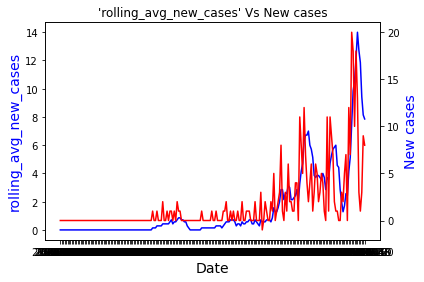

In [19]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.Date, austin_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(austin_county.Date, austin_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [20]:
dallas_county = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == 'Dallas County']

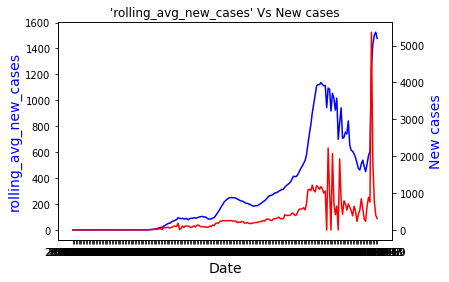

In [21]:
fig,ax = plt.subplots()
# make a plot
ax.plot(dallas_county.Date, dallas_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dallas_county.Date, dallas_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

### Rolling window to compare every 2 weeks with next 2 weeks

In [22]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data.sort_values(by=['Date'])
TX_combined_sd_inertia_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
43248,2020-01-22,Texas,48415,0,0,48415,Scurry County,48,10,13,3.89,22.7,0.4,48.6,0.65,3.24,0,16866,9.3,2020-01-22,0.00,20,55889,4.9,40.1,54.67,19,7,118,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
9752,2020-01-22,Texas,48095,0,0,48095,Concho County,48,19,21,3.03,45.2,0.6,40.3,0.24,2.79,0,4276,-2.6,2020-01-22,0.00,24,43355,2.1,56.0,66.19,4,1,85,2.82,0.3,0.04,26.0,42,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
43460,2020-01-22,Texas,48417,0,0,48417,Shackelford County,48,18,19,3.16,42.3,0.0,40.6,0.53,2.63,0,3253,9.2,2020-01-22,0.00,23,45187,0.2,11.6,53.46,4,1,169,2.82,0.3,0.04,26.0,34,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
9540,2020-01-22,Texas,48093,0,0,48093,Comanche County,48,15,17,3.62,26.0,0.2,51.1,0.55,3.07,0,13534,9.5,2020-01-22,0.00,31,47893,0.6,27.6,49.93,14,4,142,2.82,0.3,0.04,26.0,86,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['FIPS'] == 48015]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases
1484,2020-01-22,Texas,48015,0,0,48015,Austin County,48,20,16,3.30,40.4,0.3,46.4,0.56,2.75,0,29989,-4.3,2020-01-22,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,0.000000
1485,2020-01-23,Texas,48015,0,0,48015,Austin County,48,11,12,3.48,42.6,0.1,49.3,0.56,2.91,0,29989,1.3,2020-01-23,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,0.000000
1486,2020-01-24,Texas,48015,0,0,48015,Austin County,48,8,11,3.63,44.7,0.1,51.6,0.54,3.09,0,29989,7.6,2020-01-24,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,0.0,0.0,0.000000
1487,2020-01-25,Texas,48015,0,0,48015,Austin County,48,21,16,3.31,44.6,0.4,49.4,0.31,3.01,0,29989,4.8,2020-01-25,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,1.0,0.0,0.000000
1488,2020-01-26,Texas,48015,0,0,48015,Austin County,48,34,19,2.99,41.3,0.4,43.6,0.27,2.72,0,29989,-5.3,2020-01-26,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,0.0,0.5,3.5,4.6,0.20,47.700000,0.0,0.00,0.00,0,0.0,0.0,0.0,21.0,0.00,0.0000,0.00,2.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,2020-08-16,Texas,48015,3,1,48015,Austin County,48,27,22,3.38,46.0,0.4,61.0,0.28,3.10,3,29989,7.9,2020-08-16,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,56.1,1.8,14.5,35.4,0.89,58.005401,12.1,154.66,26.01,1680,331.0,4.0,0.0,140.0,0.63,0.3779,8.10,0.0,373.0,12.714286
1692,2020-08-17,Texas,48015,1,1,48015,Austin County,48,26,18,3.17,42.5,0.2,46.1,0.43,2.74,1,29989,-4.6,2020-08-17,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,56.1,1.8,14.5,35.4,0.89,57.988587,12.1,155.95,25.68,1677,332.0,4.0,0.0,140.0,0.63,0.1890,7.97,0.0,303.0,11.857143
1693,2020-08-18,Texas,48015,3,1,48015,Austin County,48,19,14,3.21,41.5,0.2,61.7,0.44,2.77,3,29989,-3.6,2020-08-18,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,56.1,1.8,14.5,35.4,0.89,57.971502,12.2,156.81,24.98,1674,335.0,4.0,0.0,140.0,0.63,0.0778,7.95,0.0,295.0,9.428571
1694,2020-08-19,Texas,48015,9,1,48015,Austin County,48,17,15,3.47,40.4,0.3,50.4,0.41,3.06,9,29989,6.5,2020-08-19,0.07,25,65365,8.7,26.4,49.67,45,16,141,2.82,0.3,0.04,26.0,51,56.1,1.8,14.5,35.4,0.89,60.671669,12.3,157.38,24.15,2132,344.0,4.0,0.0,140.0,0.63,0.1445,7.85,1.0,309.0,8.142857


In [24]:
minDate = TX_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = TX_combined_sd_inertia_data['Date'].unique()

2020-01-22


In [25]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [26]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)

[1, '2020-01-22', '2020-02-01']
[2, '2020-02-02', '2020-02-15']
[3, '2020-02-16', '2020-02-29']
[4, '2020-03-01', '2020-03-14']
[5, '2020-03-15', '2020-03-28']
[6, '2020-03-29', '2020-04-11']
[7, '2020-04-12', '2020-04-25']
[8, '2020-04-26', '2020-05-09']
[9, '2020-05-10', '2020-05-23']
[10, '2020-05-24', '2020-06-06']
[11, '2020-06-07', '2020-06-20']
[12, '2020-06-21', '2020-07-04']
[13, '2020-07-05', '2020-07-18']
[14, '2020-07-19', '2020-08-01']
[15, '2020-08-02', '2020-08-15']
[16, '2020-08-16', '2020-08-20']


In [27]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-01-22,2020-02-01
1,2,2020-02-02,2020-02-15


### Slice data for the week dataframe

In [28]:
average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (TX_combined_sd_inertia_data['Date'] >= startDate) & (TX_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  TX_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)

In [29]:
average_newCases_df.shape

(4016, 5)

In [30]:
average_newCases_df[average_newCases_df['FIPS'] == 48015]

,CTNAME,FIPS,average_per_week,startDate,endDate
7,Austin County,48015,0.000000,2020-01-22,2020-02-01
7,Austin County,48015,0.000000,2020-02-02,2020-02-15
7,Austin County,48015,0.000000,2020-02-16,2020-02-29
7,Austin County,48015,0.000000,2020-03-01,2020-03-14
7,Austin County,48015,0.030612,2020-03-15,2020-03-28
7,Austin County,48015,0.438776,2020-03-29,2020-04-11
7,Austin County,48015,0.387755,2020-04-12,2020-04-25
7,Austin County,48015,0.122449,2020-04-26,2020-05-09
7,Austin County,48015,0.459184,2020-05-10,2020-05-23
7,Austin County,48015,0.520408,2020-05-24,2020-06-06


### Verifying average per week data Eg., Los Angeles County

In [31]:
austin_county[(austin_county['Date'] >= '2020-03-01') & (austin_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']

1523    0.0
1524    0.0
1525    0.0
1526    0.0
1527    0.0
1528    0.0
1529    0.0
1530    0.0
1531    0.0
1532    0.0
1533    0.0
1534    0.0
1535    0.0
1536    0.0
Name: rolling_avg_new_cases, dtype: float64

In [32]:
average_newCases_df.head(10)

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-01-22,2020-02-01
1,Andrews County,48003,0.0,2020-01-22,2020-02-01
2,Angelina County,48005,0.0,2020-01-22,2020-02-01
3,Aransas County,48007,0.0,2020-01-22,2020-02-01
4,Archer County,48009,0.0,2020-01-22,2020-02-01
5,Armstrong County,48011,0.0,2020-01-22,2020-02-01
6,Atascosa County,48013,0.0,2020-01-22,2020-02-01
7,Austin County,48015,0.0,2020-01-22,2020-02-01
8,Bailey County,48017,0.0,2020-01-22,2020-02-01
9,Bandera County,48019,0.0,2020-01-22,2020-02-01


### Finding the % growth or reduction in 'new cases' on every 2 week average

In [33]:
average_newCases_df_ = average_newCases_df.copy()

In [34]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Austin County']
albany_avg_newCases

,CTNAME,FIPS,average_per_week,startDate,endDate
7,Austin County,48015,0.000000,2020-01-22,2020-02-01
7,Austin County,48015,0.000000,2020-02-02,2020-02-15
7,Austin County,48015,0.000000,2020-02-16,2020-02-29
7,Austin County,48015,0.000000,2020-03-01,2020-03-14
7,Austin County,48015,0.030612,2020-03-15,2020-03-28
7,Austin County,48015,0.438776,2020-03-29,2020-04-11
7,Austin County,48015,0.387755,2020-04-12,2020-04-25
7,Austin County,48015,0.122449,2020-04-26,2020-05-09
7,Austin County,48015,0.459184,2020-05-10,2020-05-23
7,Austin County,48015,0.520408,2020-05-24,2020-06-06


In [35]:
average_newCases_df.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-01-22,2020-02-01
1,Andrews County,48003,0.0,2020-01-22,2020-02-01
2,Angelina County,48005,0.0,2020-01-22,2020-02-01
3,Aransas County,48007,0.0,2020-01-22,2020-02-01
4,Archer County,48009,0.0,2020-01-22,2020-02-01


In [36]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-01-22,2020-02-01
1,Andrews County,48003,0.0,2020-01-22,2020-02-01
2,Angelina County,48005,0.0,2020-01-22,2020-02-01
3,Aransas County,48007,0.0,2020-01-22,2020-02-01
4,Archer County,48009,0.0,2020-01-22,2020-02-01


In [37]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()

(4016, 6)


,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-01-22,2020-02-01,0.0
1,Andrews County,48003,0.0,2020-01-22,2020-02-01,0.0
2,Angelina County,48005,0.0,2020-01-22,2020-02-01,0.0
3,Aransas County,48007,0.0,2020-01-22,2020-02-01,0.0
4,Archer County,48009,0.0,2020-01-22,2020-02-01,0.0


In [38]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Dallas County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
55,Dallas County,48113,0.000000,2020-01-22,2020-02-01,0.000000
306,Dallas County,48113,0.000000,2020-02-02,2020-02-15,0.000000
557,Dallas County,48113,0.000000,2020-02-16,2020-02-29,0.000000
808,Dallas County,48113,0.224490,2020-03-01,2020-03-14,0.224490
1059,Dallas County,48113,18.255102,2020-03-15,2020-03-28,18.030612
1310,Dallas County,48113,78.102041,2020-03-29,2020-04-11,59.846939
1561,Dallas County,48113,94.551020,2020-04-12,2020-04-25,16.448980
1812,Dallas County,48113,156.857143,2020-04-26,2020-05-09,62.306122
2063,Dallas County,48113,228.816327,2020-05-10,2020-05-23,71.959184
2314,Dallas County,48113,208.775510,2020-05-24,2020-06-06,-20.040816


In [39]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Houston County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
111,Houston County,48225,0.000000,2020-01-22,2020-02-01,0.000000
362,Houston County,48225,0.000000,2020-02-02,2020-02-15,0.000000
613,Houston County,48225,0.000000,2020-02-16,2020-02-29,0.000000
864,Houston County,48225,0.000000,2020-03-01,2020-03-14,0.000000
1115,Houston County,48225,0.000000,2020-03-15,2020-03-28,0.000000
1366,Houston County,48225,0.000000,2020-03-29,2020-04-11,0.000000
1617,Houston County,48225,0.285714,2020-04-12,2020-04-25,0.285714
1868,Houston County,48225,0.336735,2020-04-26,2020-05-09,0.051020
2119,Houston County,48225,5.091837,2020-05-10,2020-05-23,4.755102
2370,Houston County,48225,3.632653,2020-05-24,2020-06-06,-1.459184


In [40]:
average_newCases_df2[average_newCases_df2['FIPS'] == 48015].head(5)

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
7,Austin County,48015,0.000000,2020-01-22,2020-02-01,0.000000
258,Austin County,48015,0.000000,2020-02-02,2020-02-15,0.000000
509,Austin County,48015,0.000000,2020-02-16,2020-02-29,0.000000
760,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000
1011,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612


In [41]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-01-22,2020-02-01,0.0
1,Andrews County,48003,0.0,2020-01-22,2020-02-01,0.0
2,Angelina County,48005,0.0,2020-01-22,2020-02-01,0.0
3,Aransas County,48007,0.0,2020-01-22,2020-02-01,0.0
4,Archer County,48009,0.0,2020-01-22,2020-02-01,0.0


In [42]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [43]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-01-22,2020-02-01,0.0
1,Andrews County,48003,0.0,2020-01-22,2020-02-01,0.0
2,Angelina County,48005,0.0,2020-01-22,2020-02-01,0.0
3,Aransas County,48007,0.0,2020-01-22,2020-02-01,0.0
4,Archer County,48009,0.0,2020-01-22,2020-02-01,0.0


In [44]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [45]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
CTNAME          FIPS  startDate  endDate                       ...             
Anderson County 48001 2020-01-22 2020-02-01          0.000000  ...     0.000000
                      2020-02-02 2020-02-15          0.000000  ...     0.000000
                      2020-02-16 2020-02-29          0.000000  ...     0.000000
                      2020-03-01 2020-03-14          0.000000  ...     0.000000
                      2020-03-15 2020-03-28          0.000000  ...     0.000000
...                                                       ...  ...          ...
Zavala County   48507 2020-06-21 2020-07-04          0.612245  ...     0.091837
                      2020-07-05 2020-07-18          3.602041  ...     0.612245
                      2020-07-19 2020-08-01          6.295918  ...     3.602041
                      2020-08-02 2020-08-15          4.744898  ...     6.295918
                      2020-08-16 2020-08-20          3.428571  ...     4.744898

[4016 rows x 3 columns]

In [46]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Austin County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
7,Austin County,48015,0.000000,2020-01-22,2020-02-01,0.000000,NaN
258,Austin County,48015,0.000000,2020-02-02,2020-02-15,0.000000,0.000000
509,Austin County,48015,0.000000,2020-02-16,2020-02-29,0.000000,0.000000
760,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000,0.000000
1011,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612,0.000000
1262,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163,0.030612
1513,Austin County,48015,0.387755,2020-04-12,2020-04-25,-0.051020,0.438776
1764,Austin County,48015,0.122449,2020-04-26,2020-05-09,-0.265306,0.387755
2015,Austin County,48015,0.459184,2020-05-10,2020-05-23,0.336735,0.122449
2266,Austin County,48015,0.520408,2020-05-24,2020-06-06,0.061224,0.459184


In [47]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
4011,Wood County,48499,5.257143,2020-08-16,2020-08-20,0.053061,5.204082,0.010196
4012,Yoakum County,48501,2.714286,2020-08-16,2020-08-20,-0.153061,2.867347,-0.053381
4013,Young County,48503,3.000000,2020-08-16,2020-08-20,-2.051020,5.051020,-0.406061
4014,Zapata County,48505,5.800000,2020-08-16,2020-08-20,2.606122,3.193878,0.815974
4015,Zavala County,48507,3.428571,2020-08-16,2020-08-20,-1.316327,4.744898,-0.277419


In [48]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Dallas County']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
55,Dallas County,48113,0.000000,2020-01-22,2020-02-01,0.000000,NaN,0.000000
306,Dallas County,48113,0.000000,2020-02-02,2020-02-15,0.000000,0.000000,0.000000
557,Dallas County,48113,0.000000,2020-02-16,2020-02-29,0.000000,0.000000,0.000000
808,Dallas County,48113,0.224490,2020-03-01,2020-03-14,0.224490,0.000000,0.000000
1059,Dallas County,48113,18.255102,2020-03-15,2020-03-28,18.030612,0.224490,80.318182
1310,Dallas County,48113,78.102041,2020-03-29,2020-04-11,59.846939,18.255102,3.278368
1561,Dallas County,48113,94.551020,2020-04-12,2020-04-25,16.448980,78.102041,0.210609
1812,Dallas County,48113,156.857143,2020-04-26,2020-05-09,62.306122,94.551020,0.658968
2063,Dallas County,48113,228.816327,2020-05-10,2020-05-23,71.959184,156.857143,0.458756
2314,Dallas County,48113,208.775510,2020-05-24,2020-06-06,-20.040816,228.816327,-0.087585


## 2.2 Labeling data as per % change

In [49]:
average_newCases_df2.describe()

,FIPS,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,4016.000000,4016.000000,4016.000000,3765.000000,4016.000000
mean,48254.633466,11.139072,1.809889,9.951129,1.294614
std,146.842490,68.332000,30.944596,63.075871,8.305094
min,48001.000000,-5.000000,-710.816327,-5.000000,-5.102564
25%,48127.000000,0.000000,0.000000,0.000000,0.000000
50%,48253.000000,0.163265,0.000000,0.112245,0.000000
75%,48383.000000,2.255102,0.326531,1.775510,0.409052
max,48507.000000,1437.428571,902.428571,1373.459184,228.000000


In [50]:
austin_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Austin County']

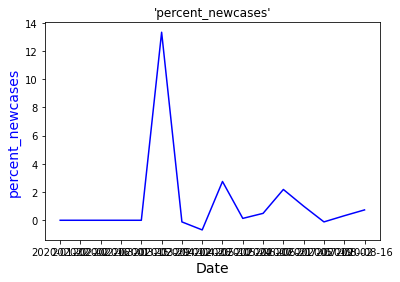

In [51]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.startDate, austin_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(austin_county.startDate, austin_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [52]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [53]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

### Determining growth label

In [54]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

4015


0.0

In [55]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  4016


In [56]:
average_newCases_df2['growth_per_day'] = growth_values

Checking mean, std dev and variance for growth data

In [57]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  -228.00000000000006
max  228.38461538461544
mean  -6.909572972321712e-05
std. deviation  11.114035572344594
variance  123.52178670334102


Positive cases

In [58]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

length diffArr:  4015
non_zero_pos_diff length:  1317


In [59]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  1.7000290064572714e-16
max  228.38461538461544
mean  3.7480713023558203
std. deviation  13.044032895516237
variance  170.14679417930972


Negative Cases

In [60]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  4015
non_zero_neg_diff length :  1323


In [61]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -228.00000000000006
max  -1.1333526709715141e-16
mean  -3.731282936173435
std. deviation  13.325846766997792
variance  177.5781920575055


### Applying Jenks Natural break

In [77]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)


[1.7000290064572714e-16, 62.00000000000001, 228.38461538461544]
[-228.00000000000006, -110.50000000000004, -1.1333526709715141e-16]


In [78]:
def determine_growth_label_inertia(x):
  if x >= -0.0021 and x <= 0.0017:
    return 'flat_growth'
  if x > 0.0017 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.1818 and x < -39.5:
    return 'drastic_decrement'


In [79]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )


## Jenks Natural breaks

In [80]:
!pip install jenkspy

In [81]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-5.102564102564105, 14.121212121212123, 80.31818181818184, 228.00000000000006]


In [82]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)


[-5.102564102564105, 7.333333333333331, 35.166666666666664, 110.50000000000004, 228.00000000000006]


In [83]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])


In [84]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())


Number of records in LessSpread: 3862
Number of records in Spread: 131
Number of records in SuperSpread: 16
Number of records in SuperSpread: 6


In [85]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)


[-5.102564102564105, 1.5151515151515158, 6.083333333333333, 14.999999999999998, 33.0, 54.0, 80.31818181818184, 154.60000000000002, 228.00000000000006]


In [86]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])


In [87]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())


Number of records in LessSpread: 3469
Number of records in Spread: 368
Number of records in SuperSpread: 104
Number of records in SuperSpread2: 51
Number of records in SuperSpread3: 11
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 4
Number of records in SuperSpread6: 3


In [88]:
average_newCases_df2.head()

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,labels,growth_label
0,Anderson County,48001,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,LessSpread,flat_growth
1,Andrews County,48003,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,LessSpread,flat_growth
2,Angelina County,48005,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,LessSpread,flat_growth
3,Aransas County,48007,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,LessSpread,flat_growth
4,Archer County,48009,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0,0.0,LessSpread,flat_growth


## 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [89]:
TX_combined_sd_inertia_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread
1,2020-01-22,Texas,48415,0,0,48415,Scurry County,48,10,13,3.89,22.7,0.4,48.6,0.65,3.24,0,16866,9.3,2020-01-22,0.00,20,55889,4.9,40.1,54.67,19,7,118,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [90]:
TX_combined_sd_inertia_data_ = TX_combined_sd_inertia_data.copy()

In [91]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [92]:
for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (TX_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (TX_combined_sd_inertia_data['Date'] >= startDate) & (TX_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  TX_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    TX_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    TX_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']

4016it [00:53, 75.33it/s]


In [93]:
TX_combined_sd_inertia_data.head(5)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label
0,2020-01-22,Texas,48001,0,0,48001,Anderson County,48,15,15,3.31,20.6,0.3,44.4,0.54,2.77,0,58057,-6.2,2020-01-22,0.22,20,43355,21.0,17.5,61.20,54,12,95,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
1,2020-01-22,Texas,48415,0,0,48415,Scurry County,48,10,13,3.89,22.7,0.4,48.6,0.65,3.24,0,16866,9.3,2020-01-22,0.00,20,55889,4.9,40.1,54.67,19,7,118,2.82,0.3,0.04,26.0,16,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
2,2020-01-22,Texas,48095,0,0,48095,Concho County,48,19,21,3.03,45.2,0.6,40.3,0.24,2.79,0,4276,-2.6,2020-01-22,0.00,24,43355,2.1,56.0,66.19,4,1,85,2.82,0.3,0.04,26.0,42,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
3,2020-01-22,Texas,48417,0,0,48417,Shackelford County,48,18,19,3.16,42.3,0.0,40.6,0.53,2.63,0,3253,9.2,2020-01-22,0.00,23,45187,0.2,11.6,53.46,4,1,169,2.82,0.3,0.04,26.0,34,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth
4,2020-01-22,Texas,48093,0,0,48093,Comanche County,48,15,17,3.62,26.0,0.2,51.1,0.55,3.07,0,13534,9.5,2020-01-22,0.00,31,47893,0.6,27.6,49.93,14,4,142,2.82,0.3,0.04,26.0,86,0.0,0.5,3.5,4.6,0.2,47.7,0.0,0.0,0.0,0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth


In [94]:
TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

Date                                          714
Province_State                                714
FIPS                                          714
New cases                                     714
mask_rule_active                              714
CTFIPS                                        714
CTNAME                                        714
STFIPS                                        714
Social distancing index                       714
% staying home                                714
Trips/person                                  714
% out-of-county trips                         714
% out-of-state trips                          714
Miles/person                                  714
Work trips/person                             714
Non-work trips/person                         714
New COVID cases                               714
Population                                    714
% change in consumption                       714
date                                          714


In [95]:
TX_combined_sd_inertia_data.shape

(53212, 56)

In [96]:
TX_combined_sd_inertia_data['label'] = TX_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

### Export

In [97]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'TX_sd_inertia_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
TX_combined_sd_inertia_data.to_csv(location+filename,index=False)

TX_sd_inertia_labeledData_Sep18.csv


In [98]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,CTNAME,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,labels,growth_label
